# Lagrange Interpolation

Imagine that we have a dataset with $N$ points, $\{x_0, x_1, \ldots, x_{N-1}\}$ and associated function values
$\{f_0, f_1, \ldots, f_{N-1}\}$.  We can write a general polynomial interpolation routine that passes through _all $N$ points_ using the [Lagrange polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial).

The basic idea is to create $N$ _basis functions_ of the form:

$$\ell_m(x) = \prod_{n=0, n\ne m}^{N-1} \frac{x - x_n}{x_m - x_n}$$

This has the property that:

$$\ell_m(x_n) = \delta_{mn}$$

We can then write our interpolant as:

$$f(x) = \sum_{m=0}^{N-1} \ell_m f_m$$

## Quadratic example

Consider fitting a quadratic to three points:

$$(x_0, f_0), (x_1,f_1), (x_2, f_2)$$

Let's imagine that they are evenly spaced, with a spacing $\Delta x$.

The three basis functions are:

\begin{align*}
\ell_0 &= \frac{x - x_1}{x_0 - x_1} \cdot
          \frac{x-x_2}{x_0 - x_2} =
         \frac{(x-x_1)(x-x_2)}{2 \Delta x^2} \\
\ell_1 &= \frac{x - x_0}{x_1 - x_0} \cdot
          \frac{x-x_2}{x_1 - x_2} =
         -\frac{(x-x_0)(x-x_2)}{\Delta x^2} \\
\ell_2 &= \frac{x - x_0}{x_2 - x_0} \cdot
          \frac{x-x_1}{x_2 - x_1} =
         \frac{(x-x_0)(x-x_1)}{2 \Delta x^2}
\end{align*}

and the quadratic polynomial is:

$$
f(x) = \frac{(x-x_1)(x-x_2)}{2 \Delta x^2} f_0 -
          \frac{(x-x_0)(x-x_2)}{\Delta x^2} f_1 +
          \frac{(x-x_0)(x-x_1)}{2 \Delta x^2} f_2
$$

Let's implement this

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f_lagrange(x0, xv, fv):
    """ xv, fv are the 3 points, x9 is where we want to evaluate """
    dx = x[1] - x[0]

    return (x0 - xv[1])*(x0-xv[2])*fv[0]/(2.0*dx**2) - \
           (x0 - xv[0])*(x0-xv[2])*fv[1]/(dx**2) + \
           (x0 - xv[0])*(x0-xv[1])*fv[2]/(2.0*dx**2)

We'll look at several different sets of points.  For each, we'll plot the interpolated parabola through the 3 points.

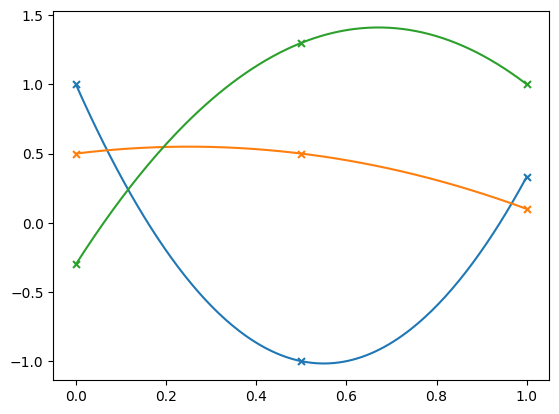

In [3]:
fig, ax = plt.subplots()

# grid points where our data is
x = np.array([0.0, 0.5, 1.0])

f1 = np.array([1.0, -1.0, 1.0/3.0])
f2 = np.array([0.5, 0.5, 0.1])
f3 = np.array([-0.3, 1.3, 1.0])

xfine = np.linspace(0.0, 1.0, 200)

for farray in (f1, f2, f3):
    ax.scatter(x, farray, marker="x", s=25)
    ax.plot(xfine, f_lagrange(xfine, x, farray))

Notice that the interpolated values exceed the range of $\{f_1, f_2, f_3\}$.  For some applications we may not to introduce new extrema.

```{tip}
Lagrange interpolation is not very computationally efficient, since you need to recompute the basis functions for each point.  There are more efficient ways to compute this, like [barycentric form](https://en.wikipedia.org/wiki/Lagrange_polynomial#Barycentric_form) that are algebraically equivalent.
```

## Runge's phenomena

Lagrange interpolation also suffers from [Runge's phenomenon](https://en.wikipedia.org/wiki/Runge%27s_phenomenon) if used with equally spaced points.  This gives rise to larges osciallations at the end of the interpolating interval if we use very high-order polynomial.

Let's write a general Lagrange interpolation class and test it out on some different functions.

In [4]:
class LagrangePoly:
    """ a general class for creating a Lagrange polynomial 
    representation of a function """

    def __init__(self, xmin, xmax, N, func, chebyshev=False):
        self.N = N
        self.xmin = xmin
        self.xmax = xmax
        self.func = func

        if chebyshev:
            k = np.arange(N) + 1
            self.xp = 0.5 * (xmin + xmax) + 0.5 * (xmax - xmin) * np.cos((2 * k -1) * np.pi / (2 * N))
        else:
            self.xp = np.linspace(self.xmin, self.xmax, self.N)
        self.fp = func(self.xp)

    def evalf(self, x0):
        """ given a point x0 and a function func, fit a Lagrange
        polynomial through the control points and return the
        interpolated value at x """

        f = 0.0

        # sum over points
        for m in range(len(self.xp)):

            # create the Lagrange basis polynomial for point m
            l = 1

            for n in range(len(self.xp)):
                if n == m:
                    continue

                l *= (x0 - self.xp[n])/(self.xp[m] - self.xp[n])

            f += self.fp[m]*l

        return f

Let's test it out on a $\tanh$ profile

In [5]:
def func(x):
    return 0.5 * (1.0 + np.tanh((x - 1.0) / 0.1))

In [6]:
N = 11
xmin = 0.0
xmax = 2.0

l = LagrangePoly(xmin, xmax, N, func)

Let's compute the interpolated value at a lot of points and also compute the error with respect to the exact function value.

In [7]:
# xx are the finely grided data that we will interpolate at to get
# the interpolated function values ff
xx = np.linspace(xmin, xmax, 200)
ff = np.zeros_like(xx)

for n, v in enumerate(xx):
    ff[n] = l.evalf(v)

# exact function values at the interpolated points
fexact = func(xx)

In [8]:
def plot_result(xx, ff, fexact):

    # compute the error
    e = fexact - ff

    fig = plt.figure()
    ax = fig.add_subplot(211)

    ax.scatter(l.xp, l.fp, marker="x", s=30)
    ax.plot(xx, ff)

    ax.plot(xx, fexact, color="0.5")

    ax = fig.add_subplot(212)

    ax.plot(xx, e)
    ax.set_xlabel("x")
    ax.set_ylabel("error")
    fig.tight_layout()

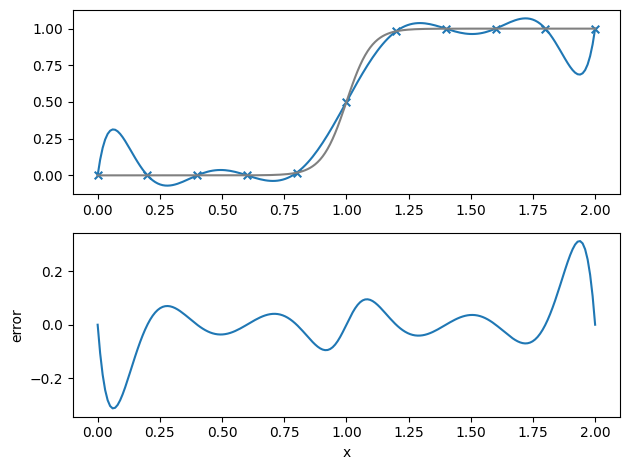

In [9]:
plot_result(xx, ff, fexact)

What happens as we increase the number of data samples, $N$?

## Chebyshev nodes

If we are free to pick the points where we sample the function, we can do a lot better, and minimize the Runge's phenomena.  Sampling $f(x)$ at the [Chebyshev nodes](https://en.wikipedia.org/wiki/Chebyshev_nodes):

$$x_k = \frac{1}{2}(a +b) + \frac{1}{2} (b-a) \cos \left (\frac{2k - 1}{2n}\pi \right )\, , \quad k = 1, \ldots n$$

where $[a, b]$ is the domain, works well.

Let's try this out

In [10]:
l = LagrangePoly(xmin, xmax, N, func, chebyshev=True)

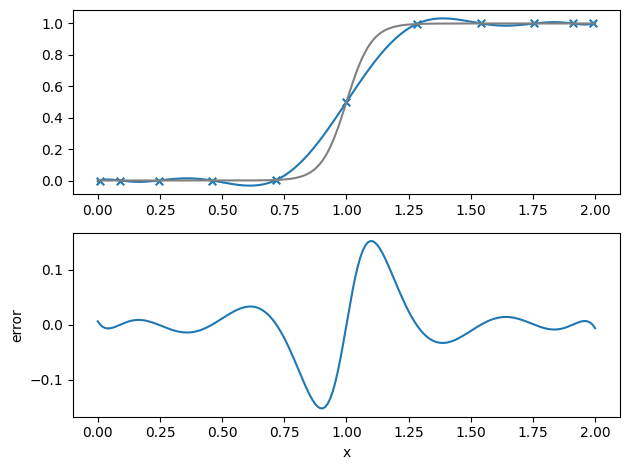

In [11]:
for n, v in enumerate(xx):
    ff[n] = l.evalf(v)

# exact function values at the interpolated points
fexact = func(xx)

plot_result(xx, ff, fexact)